<a href="https://colab.research.google.com/github/DeltiKron/School2019/blob/master/deblending_with_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep learning for galaxy deblending

##### Alexandre Boucaud (APC) & Marc Huertas-Company (LERMA)

1. [Introduction](#Introduction)
2. [Data](#Data)
3. [Workflow](#Workflow)
4. [Evaluation](#Detection-evaluation)
5. [Local testing/exploration](#Local-testing)

## Introduction

In astronomical images, the projection effects may cause two or more galaxies to overlap. When they are barely indistinguishable from one another, they are referred to as _blended_ and this can bias astrophysical estimators such as the morphology of galaxies or the shear (weak gravitational lensing distortion).  
As the sensitivity of imaging devices grows, a high fraction of galaxies appear _blended_ in the images, which is a known and important issue for current and upcoming galaxy surveys.  

In order not to discard such a wealth of information, it is key to develop methods to enable astronomers to alleviate such effect.
We can foresee some features that would help, in which machine learning could provide a solution:
- classify an image as containing isolated/blended objects  
  ___binary classification___
- count the number of blended sources in a blended image  
  ___regression / object detection___
- find the contours of each object  
  ___object detection/segmentation___
- ...

In this exercice, we will approach the third item, the detection of contours, but in a constrained way : the images will only contain **two galaxies** and the goal will be to find the **contours of the central galaxy**.

## Code

Install the `dltools` lib that contains helper methods for training a deep neural network on the provided blended galaxy dataset.

In [1]:
!pip install git+https://github.com/aboucaud/deeplearning4astro_tools

  Cloning https://github.com/aboucaud/deeplearning4astro_tools to /tmp/pip-req-build-xag44h38
  Stored in directory: /tmp/pip-ephem-wheel-cache-vv19gpmz/wheels/91/6d/a6/29cbf3606b451d18c22157c8768ca581598a6b39179ae93dfa
Successfully built dltools


## Necessary imports

In [0]:
import os
import sys
import tarfile
from urllib.request import urlretrieve

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
from dltools.detector import ObjectDetector
from dltools.metric import iou_bitmap
from dltools.plots import plot_history
from dltools.plots import plot_random_results

## Data

Download the data

In [0]:
datadir = "data"
# Use the big dataset (during the school, use this only on Colab, otherwise set to False)
full = True

In [0]:
URL = "https://www.apc.univ-paris7.fr/Downloads/comput/aboucaud"
FOLDER = "ed127"
FILES = [
    "test_blends_mini.npy",
    "test_target_masks_mini.npy",
    "train_blends_mini.npy",
    "train_target_masks_mini.npy",

]
BIG_FILES = [
    "masks.tar.gz",
    "blends.tar.gz",
]

def main(output_dir, delete_archive=False, full=False):
    if full:
        files = BIG_FILES
    else:
        files = FILES

    urls = [
        f"{URL}/{FOLDER}/{filename}"
        for filename in files
    ]

    if not os.path.exists(output_dir):
        print(f"Creating directory {output_dir}")
        os.mkdir(output_dir)

    for url, filename in zip(urls, files):
        output_file = os.path.join(output_dir, filename)

        if os.path.exists(output_file):
            print(f"{filename} already downloaded.")
            continue

        print(f"Downloading from {url} ...")
        urlretrieve(url, filename=output_file)
        print(f"=> File saved as {output_file}")

        if filename.endswith("tar.gz"):
            print("Extracting tarball..")
            with tarfile.open(output_file, "r:gz") as f:
                f.extractall(output_dir)
            print("Done.")

            if delete_archive:
                os.remove(output_file)
                print(f"=> File {output_file} removed.")

In [7]:
main(output_dir=datadir, full=full, delete_archive=True)                

Creating directory data
=> File saved as data/masks.tar.gz
Extracting tarball..
Done.
=> File data/masks.tar.gz removed.
=> File saved as data/blends.tar.gz
Extracting tarball..
Done.
=> File data/blends.tar.gz removed.


## Load data

Load the train and test datasets in memory-mapping mode. This does not actually load the data into memory but creates a mapping to it to easily retrieve chunks of the data using its indices when needed. 

In [0]:
suffix = "" if full else "_mini"

X_train = np.load(os.path.join(datadir, f"train_blends{suffix}.npy"), mmap_mode='r')
Y_train = np.load(os.path.join(datadir, f"train_target_masks{suffix}.npy"), mmap_mode='r')[:, 1, :, :]

X_test = np.load(os.path.join(datadir, f"test_blends{suffix}.npy"), mmap_mode='r')
Y_test = np.load(os.path.join(datadir, f"test_target_masks{suffix}.npy"), mmap_mode='r')[:, 1, :, :]

In [0]:
def plot_data_basic(idx):
    titles = [
        'blended galaxies',
        'segmap of companion galaxy'
    ]

    fig_size = (12, 6)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=fig_size)
    axes[0].imshow(X_train[idx], cmap='viridis')
    axes[1].imshow(Y_train[idx], cmap='Greys_r')
    for title, ax in zip(titles, axes):
        ax.set_title(title)
        ax.set_axis_off()

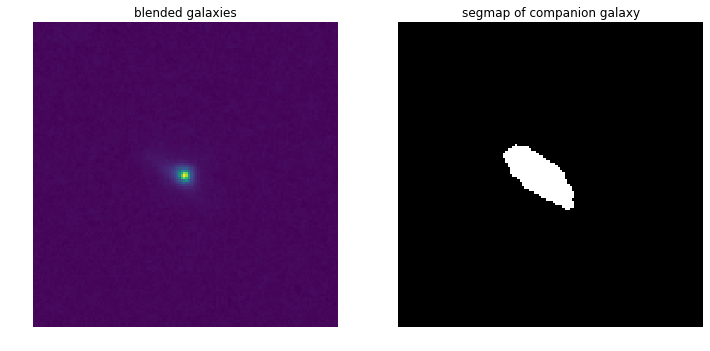

In [19]:
index = np.random.randint(len(X_train))
plot_data_basic(index)


The goal in this exercise is to create a deep learning model that produces the segmentation map (mask) of the companion galaxy from the image of the blend. This can be seen as a classification task where each pixel of the image has to be classified as "galaxy companion" or "not galaxy companion".

## Workflow

In the `dltools` package we have implemented a class called `ObjectDetector`, with two main methods implemented : `fit()` and `predict()`

However `ObjectDetector` is missing a model that **you need to provide**. You can have a look at how the ObjectDetector was implemented to run your model. It will give you an idea of how to organize your code.

In [0]:
ObjectDetector??

The model needs to take the image blend as input and produce an other image as output.

## Detection evaluation

For image detection a classical metric is the ***Intersection over Union (IoU)*** also referred to as ***Jaccard index*** and defined as

$$ IoU(A, B) =  \dfrac{|A \cap B|}{|A \cup B|} $$

This metric is very sensitive to small shifts or area difference between truth and prediction.

Typically, a value of IoU superior to 0.5 is used to define a good detection.

An implementation of the IoU for a series of flatten segmentation images $\in [0, 1]$ can be found in

In [0]:
iou_bitmap??

This is the metric used to score the segmentation.

## Model

The model is the part where you intervention is needed. A very basic (working) model is implemented below. It has two convolution layers. While it is very fast to train, it does not yield good results.

Try to navigate the web/github to find appropriate models for this image segmentation task. Or build upon this existing model by complexifying it.

In [0]:
# CHANGE HERE
# ===========

from keras.models import Sequential, Model
from keras.layers import (
    Conv2D,
    Dropout,
    Input,
    MaxPooling2D,
    concatenate,
    Conv2DTranspose,
    UpSampling2D,
)
from keras.layers.noise import GaussianNoise

input_shape = (128, 128, 1)
output_channels = 1
last_activation = "sigmoid"

def model():
    model = Sequential()
    model.add(
        Conv2D(
            15, (3, 3), 
            input_shape=input_shape,
            activation="relu", 
            padding="same",
        )
    )
    model.add(
        Conv2D(
            output_channels, (3, 3), 
            activation=last_activation,
            padding="same", 
        )
    )

    return model


In [21]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

  
def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model
  
fancy_model = unet(input_size=input_shape)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


## Train the model

In [0]:
# CHANGE HERE THE NUMBER OF EPOCHS OR THE BATCH SIZE
obj = ObjectDetector(fancy_model, batch_size=16, epoch=5, model_check_point=True)

In [24]:
history = obj.fit(X_train, Y_train)

Epoch 1/3
450/450 [==============================] - 274s 609ms/step - loss: 0.0691 - val_loss: 0.0603

Epoch 00001: val_loss improved from inf to 0.06033, saving model to ./fcnn_weights_best.h5
Epoch 2/3
450/450 [==============================] - 268s 596ms/step - loss: 0.0502 - val_loss: 0.0415

Epoch 00002: val_loss improved from 0.06033 to 0.04150, saving model to ./fcnn_weights_best.h5
Epoch 3/3
450/450 [==============================] - 268s 596ms/step - loss: 0.0368 - val_loss: 0.0356

Epoch 00003: val_loss improved from 0.04150 to 0.03563, saving model to ./fcnn_weights_best.h5


## Predict on the test set and score the model

In [25]:
score = obj.predict_score(X_test.squeeze(), Y_test)

print(f"Score: {score:.2f}")

Score: 0.71


### Plot the history

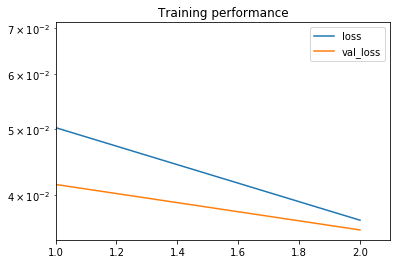

In [26]:
plot_history(history)

### Plot some examples

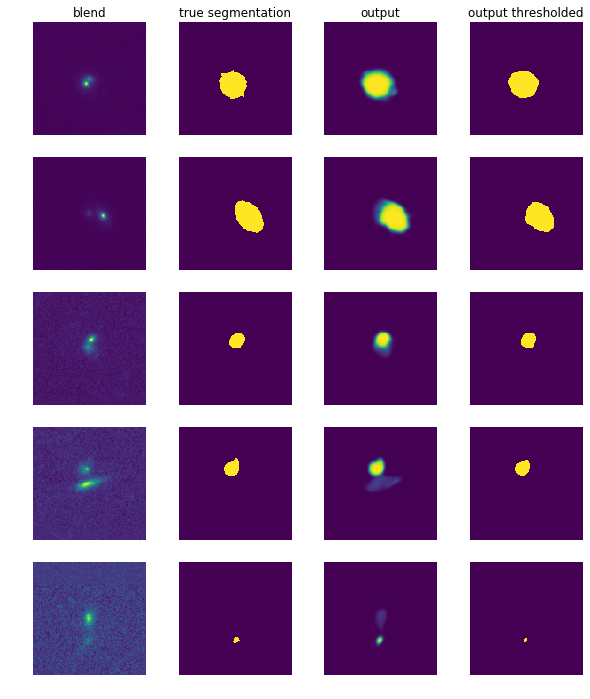

In [29]:
plot_random_results(obj.model_, X_test, Y_test)

## Exercise : modify the model and iterate

## GOOD LUCK !